In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/COMP 8740/Sensorless drive/'
%ls

/content/drive/MyDrive/COMP 8740/Sensorless drive
 Extra/             Final_2_Results/  'Old Final'/
 Final_1.ipynb      Final_3.ipynb      Sensorless_drive_diagnosis.txt
 Final_1_Results/   Final_3_Results/
 Final_2.ipynb      Final_Scripts/


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
col_names = [f'feat{i+1}' for i in range(48)] + ['class']
df = pd.read_csv('Sensorless_drive_diagnosis.txt', header=None, names=col_names, sep=' ')
le = LabelEncoder()
df['class_enc'] = le.fit_transform(df['class'])
target_names = [str(c) for c in le.classes_]

In [ ]:
X = df.drop(columns=['class', 'class_enc'])
y = df['class_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
unique_test_labels = np.unique(y_test)

In [ ]:
k_values = [3, 5, 7]
reduced_datasets = {}

for k in k_values:
    nn = NearestNeighbors(n_neighbors=k+1).fit(X_train_scaled)
    distances, indices = nn.kneighbors(X_train_scaled)
    neighbors = indices[:, 1:]
    to_remove = [i for i in range(len(X_train_scaled)) if all(y_train.iloc[n] == y_train.iloc[i] for n in neighbors[i])]
    to_keep = [i for i in range(len(X_train_scaled)) if i not in to_remove]

    X_train_reduced = X_train_scaled[to_keep]
    y_train_reduced = y_train.iloc[to_keep]

    reduced_datasets[k] = {
        'X_train_reduced': X_train_reduced,
        'y_train_reduced': y_train_reduced
    }
    print(f"K: {k} -> Samples Kept: {len(to_keep)}")

K: 3 -> Samples Kept: 20620
K: 5 -> Samples Kept: 26670
K: 7 -> Samples Kept: 30217


In [ ]:
def find_voronoi_neighbors(vor):
    neighbors = {i: set() for i in range(len(vor.points))}
    for p1, p2 in vor.ridge_points:
        neighbors[p1].add(p2)
        neighbors[p2].add(p1)
    return neighbors

In [ ]:
pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train_scaled)
X_test_3d = pca_3d.transform(X_test_scaled)
print(f"Variance captured by 3 components: {pca_3d.explained_variance_ratio_.sum():.4f}")

vor = Voronoi(X_train_3d)

neighbors = find_voronoi_neighbors(vor)
to_remove = [i for i in range(len(X_train_3d)) if all(y_train[n] == y_train[i] for n in neighbors[i])]
to_keep = [i for i in range(len(X_train_3d)) if i not in to_remove]
reduced_datasets['PCA+Voronoi'] = {
    'X_train_reduced': X_train_3d[to_keep],
    'y_train_reduced': y_train[to_keep]
}
print(f"PCA+Voronoi Neighbors -> Samples Kept: {len(to_keep)}")

Variance captured by 3 components: 0.4116
PCA+Voronoi Neighbors -> Samples Kept: 33706


In [ ]:
print('Neighbors k=3:')
print(reduced_datasets[3]['y_train_reduced'].value_counts())

print('\n\nNeighbors k=5:')
print(reduced_datasets[5]['y_train_reduced'].value_counts())

print('\n\nNeighbors k=7:')
print(reduced_datasets[7]['y_train_reduced'].value_counts())

print('\n\nPCA+Voronoi:')
print(reduced_datasets['PCA+Voronoi']['y_train_reduced'].value_counts())

Neighbors k=3:
class_enc
4     2851
5     2539
7     2462
1     2357
0     2330
9     2200
2     1915
8     1907
3     1871
6      180
10       8
Name: count, dtype: int64


Neighbors k=5:
class_enc
4     3471
7     3153
5     3108
1     3035
0     2964
9     2806
2     2653
3     2588
8     2542
6      335
10      15
Name: count, dtype: int64


Neighbors k=7:
class_enc
4     3803
7     3493
1     3419
5     3417
0     3367
2     3129
9     3125
3     3015
8     2962
6      464
10      23
Name: count, dtype: int64


PCA+Voronoi:
class_enc
0     4132
4     3986
3     3739
5     3610
7     3607
2     3600
9     3462
8     3368
1     3365
6      629
10     208
Name: count, dtype: int64


In [ ]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
scoring = {'accuracy': 'accuracy'}

all_results_lr = []
test_accuracies_lr = []

for kk in [3, 5, 7, 'PCA+Voronoi']:
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    y_train_reduced = reduced_datasets[kk]['y_train_reduced']

    model = LogisticRegression(max_iter=10000, random_state=42)
    grid_search = GridSearchCV(
        model, param_grid_lr, cv=3, scoring=scoring, refit='accuracy',
        verbose=2, return_train_score=True, n_jobs=-1
    )
    grid_search.fit(X_train_reduced, y_train_reduced)

    print(f"Best Parameters for k={kk}:", grid_search.best_params_)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['kk'] = kk
    all_results_lr.append(results_df)

    if kk == 'PCA+Voronoi':
        X_test_used = X_test_3d
    else:
        X_test_used = X_test_scaled

    y_pred = grid_search.predict(X_test_used)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    test_accuracies_lr.append({
        'kk': kk,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1
    })

combined_results_lr_df = pd.concat(all_results_lr, ignore_index=True)
test_accuracies_lr_df = pd.DataFrame(test_accuracies_lr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for k=3: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for k=5: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for k=7: {'C': 10, 'solver': 'lbfgs'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for k=PCA+Voronoi: {'C': 1, 'solver': 'lbfgs'}


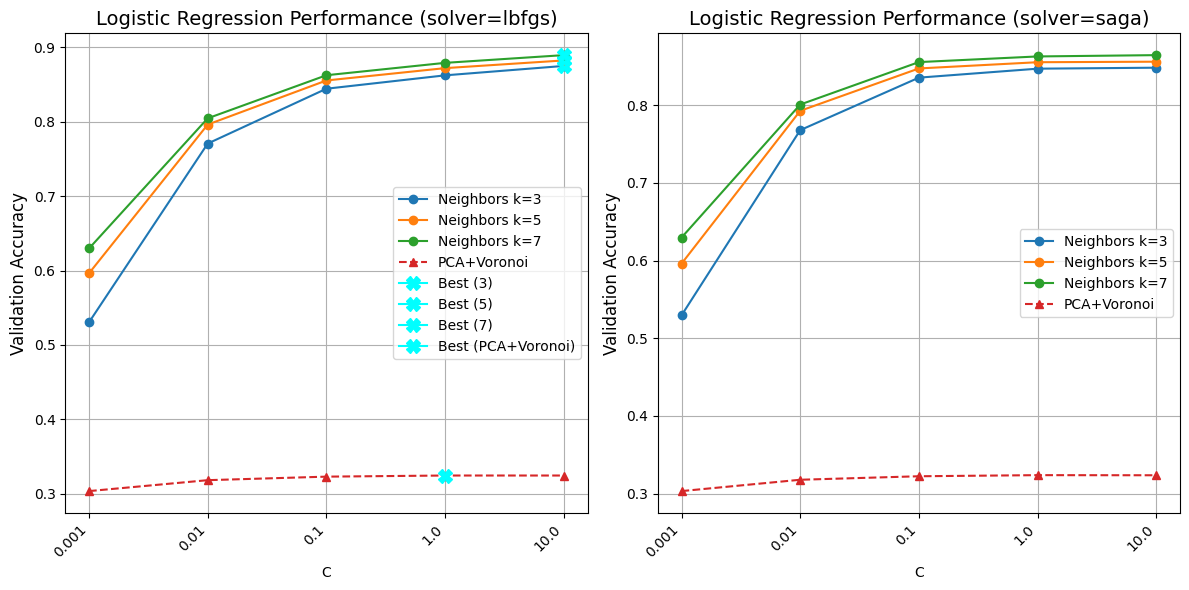

In [ ]:
combined_results_lr_df['param_combination'] = (
    combined_results_lr_df['param_C'].astype(str) + " | " + combined_results_lr_df['param_solver']
)

results_lr_lbfgs = combined_results_lr_df[combined_results_lr_df['param_solver'] == 'lbfgs'].copy()
results_lr_saga = combined_results_lr_df[combined_results_lr_df['param_solver'] == 'saga'].copy()

results_lr_lbfgs['param_combination'] = results_lr_lbfgs['param_combination'].apply(lambda x: x.split(' | ')[0])
results_lr_saga['param_combination'] = results_lr_saga['param_combination'].apply(lambda x: x.split(' | ')[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k in combined_results_lr_df['kk'].unique():
    subset_all = combined_results_lr_df[combined_results_lr_df['kk'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_lbfgs = results_lr_lbfgs[results_lr_lbfgs['kk'] == k]
    if k == 'PCA+Voronoi':
        ax1.plot(subset_lbfgs['param_combination'], subset_lbfgs['mean_test_accuracy'], marker='^', linestyle='--', label=f'{k}')
    else:
        ax1.plot(subset_lbfgs['param_combination'], subset_lbfgs['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_solver'] == 'lbfgs':
        ax1.plot(str(best_row['param_C']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax1.set_title('Logistic Regression Performance (solver=lbfgs)', fontsize=14)
    ax1.set_xlabel('C', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
    ax1.legend()
    ax1.grid(True)

    subset_saga = results_lr_saga[results_lr_saga['kk'] == k]
    if k == 'PCA+Voronoi':
        ax2.plot(subset_saga['param_combination'], subset_saga['mean_test_accuracy'], marker='^', linestyle='--', label=f'{k}')
    else:
        ax2.plot(subset_saga['param_combination'], subset_saga['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_solver'] == 'saga':
        ax2.plot(str(best_row['param_C']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax2.set_title('Logistic Regression Performance (solver=saga)', fontsize=14)
    ax2.set_xlabel('C', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()
plt.show()

In [ ]:
combined_results_lr_df.to_csv('Final_Scripts/Final3/GS_LR.csv', index=0)
test_accuracies_lr_df.to_csv('Final_Scripts/Final3/Test_LR.csv', index=0)

In [ ]:
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
}
scoring = {
    'accuracy': 'accuracy',
}

results_dt = []
test_accuracies_dt = []

for kk in [3, 5, 7, 'PCA+Voronoi']:
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    y_train_reduced = reduced_datasets[kk]['y_train_reduced']

    model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_dt, cv=3,
        scoring=scoring, return_train_score=True, verbose=2, refit='accuracy', n_jobs=-1)
    grid_search.fit(X_train_reduced, y_train_reduced)
    print(f"Best Parameters for k={kk}:", grid_search.best_params_)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['kk'] = kk
    results_dt.append(results_df)

    if kk == 'PCA+Voronoi':
        X_test = X_test_3d
    else:
        X_test = X_test_scaled

    y_test = y_test
    y_pred = grid_search.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    test_accuracies_dt.append({'kk': kk, 'test_accuracy': test_acc, 'test_precision': test_prec, 'test_recall': test_rec, 'test_f1': test_f1})

results_dt_df = pd.concat(results_dt, ignore_index=True)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for k=3: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for k=5: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for k=7: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for k=PCA+Voronoi: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
test_accuracies_dt_df = pd.DataFrame(test_accuracies_dt)
test_accuracies_dt_df

,kk,test_accuracy,test_precision,test_recall,test_f1
0,3,0.980687,0.980934,0.980687,0.980717
1,5,0.979405,0.979792,0.979406,0.979430
2,7,0.981200,0.981571,0.981201,0.981214
3,PCA+Voronoi,0.732268,0.733209,0.732247,0.732373


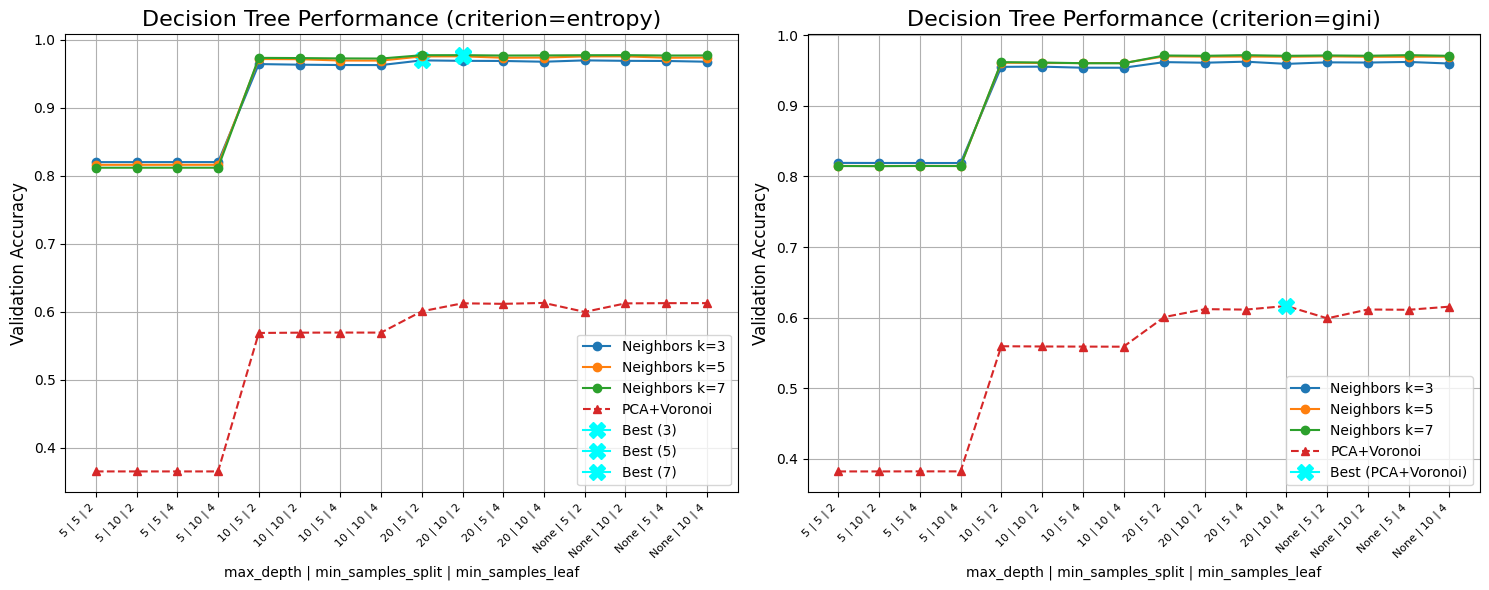

In [ ]:
results_dt_df['param_combination'] = (
    results_dt_df['param_max_depth'].astype(str) + " | " + results_dt_df['param_min_samples_split'].astype(str) + " | " + results_dt_df['param_min_samples_leaf'].astype(str) + " | " +
    results_dt_df['param_criterion'].astype(str))

results_dt_e1 = results_dt_df[results_dt_df['param_criterion'] == 'entropy'].copy()
results_dt_e2 = results_dt_df[results_dt_df['param_criterion'] == 'gini'].copy()

results_dt_e1['param_combination'] = results_dt_e1['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))
results_dt_e2['param_combination'] = results_dt_e2['param_combination'].apply(lambda x: ' | '.join(x.split(' | ')[:3]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for k in results_dt_df['kk'].unique():
    subset_all = results_dt_df[results_dt_df['kk'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_e1 = results_dt_e1[results_dt_e1['kk'] == k]
    if k == 'PCA+Voronoi':
        ax1.plot(subset_e1['param_combination'], subset_e1['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax1.plot(subset_e1['param_combination'], subset_e1['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_criterion'] == 'entropy':
        best_comb = ' | '.join([str(best_row['param_max_depth']), str(best_row['param_min_samples_split']), str(best_row['param_min_samples_leaf'])])
        if best_comb in subset_e1['param_combination'].values:
            ax1.plot(best_comb, best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=12, label=f'Best ({k})')

    ax1.set_title('Decision Tree Performance (criterion=entropy)', fontsize=16)
    ax1.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
        x_tick.set_fontsize(8)
    ax1.legend()
    ax1.grid(True)

    subset_e2 = results_dt_e2[results_dt_e2['kk'] == k]
    if k == 'PCA+Voronoi':
        ax2.plot(subset_e2['param_combination'], subset_e2['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax2.plot(subset_e2['param_combination'], subset_e2['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_criterion'] == 'gini':
        best_comb = ' | '.join([str(best_row['param_max_depth']), str(best_row['param_min_samples_split']), str(best_row['param_min_samples_leaf'])])
        if best_comb in subset_e2['param_combination'].values:
            ax2.plot(best_comb, best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=12, label=f'Best ({k})')

    ax2.set_title('Decision Tree Performance (criterion=gini)', fontsize=16)
    ax2.set_xlabel('max_depth | min_samples_split | min_samples_leaf', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
        x_tick.set_fontsize(8)
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()

plt.show()

In [ ]:
results_dt_df.to_csv('Final_Scripts/Final3/GS_DT.csv', index=0)
test_accuracies_dt_df.to_csv('Final_Scripts/Final3/Test_DT.csv', index=0)

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'p': [1, 2]
}
scoring = {
    'accuracy': 'accuracy',
}
all_results_knn = []
test_accuracies_knn = []

for kk in [3, 5, 7, 'PCA+Voronoi']:
    X_train_reduced = reduced_datasets[kk]['X_train_reduced']
    y_train_reduced = reduced_datasets[kk]['y_train_reduced']

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring=scoring, refit='accuracy', verbose=2, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_reduced, y_train_reduced)
    print(f"Best Parameters for k={kk}:", grid_search.best_params_)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['kk'] = kk
    all_results_knn.append(results_df)

    if kk == 'PCA+Voronoi':
        X_test = X_test_3d
    else:
        X_test = X_test_scaled
    y_test = y_test
    y_pred = grid_search.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    test_accuracies_knn.append({
        'kk': kk, 'test_accuracy': test_acc, 'test_precision': test_prec,
        'test_recall': test_rec, 'test_f1': test_f1})

combined_results_knn_df = pd.concat(all_results_knn, ignore_index=True)
test_accuracies_knn_df = pd.DataFrame(test_accuracies_knn)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Parameters for k=3: {'n_neighbors': 15, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Parameters for k=5: {'n_neighbors': 15, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Parameters for k=7: {'n_neighbors': 15, 'p': 1}
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best Parameters for k=PCA+Voronoi: {'n_neighbors': 13, 'p': 2}


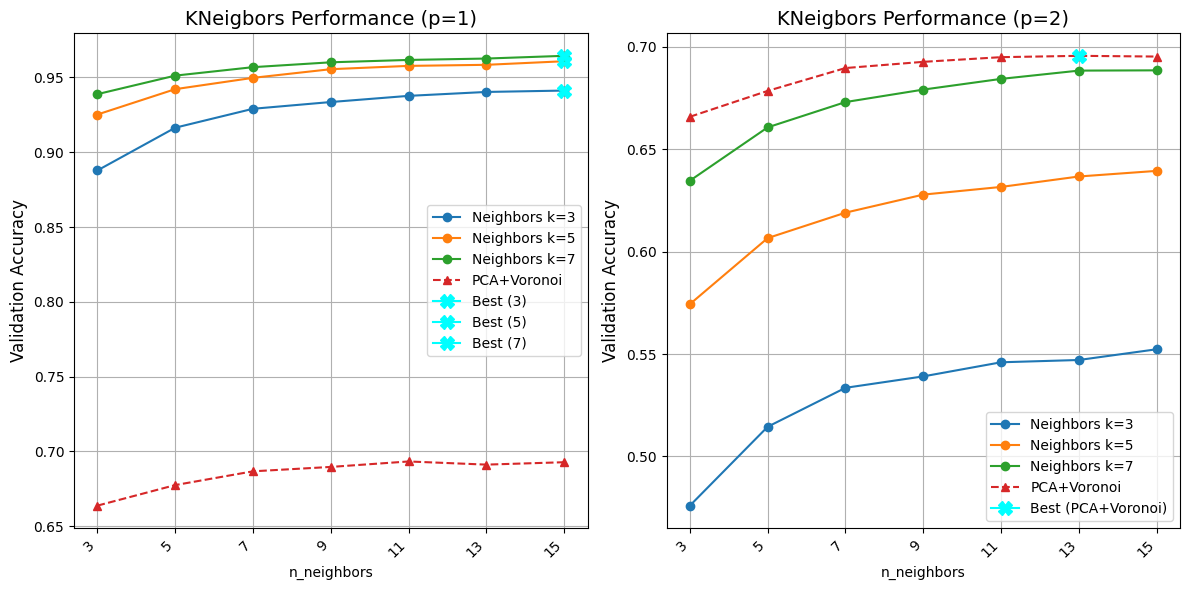

In [ ]:
combined_results_knn_df['param_combination'] = (
    combined_results_knn_df['param_n_neighbors'].astype(str) + " | " + combined_results_knn_df['param_p'].astype(str)
)
results_knn_p1 = combined_results_knn_df[combined_results_knn_df['param_p'] == 1].copy()
results_knn_p2 = combined_results_knn_df[combined_results_knn_df['param_p'] == 2].copy()

results_knn_p1['param_combination'] = results_knn_p1['param_combination'].apply(lambda x: x.split(' | ')[0])
results_knn_p2['param_combination'] = results_knn_p2['param_combination'].apply(lambda x: x.split(' | ')[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k in combined_results_knn_df['kk'].unique():
    subset_all = combined_results_knn_df[combined_results_knn_df['kk'] == k]
    best_row = subset_all.loc[subset_all['mean_test_accuracy'].idxmax()]
    subset_p1 = results_knn_p1[results_knn_p1['kk'] == k]
    if k == 'PCA+Voronoi':
        ax1.plot(subset_p1['param_combination'], subset_p1['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax1.plot(subset_p1['param_combination'], subset_p1['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_p'] == 1:
        ax1.plot(str(best_row['param_n_neighbors']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax1.set_title('KNeigbors Performance (p=1)', fontsize=14)
    ax1.set_xlabel('n_neighbors', fontsize=10)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for x_tick in ax1.get_xticklabels():
        x_tick.set_ha('right')
    ax1.legend()
    ax1.grid(True)

    subset_p2 = results_knn_p2[results_knn_p2['kk'] == k]
    if k == 'PCA+Voronoi':
        ax2.plot(subset_p2['param_combination'], subset_p2['mean_test_accuracy'], marker='^', label=f'{k}', linestyle='--')
    else:
        ax2.plot(subset_p2['param_combination'], subset_p2['mean_test_accuracy'], marker='o', label=f'Neighbors k={k}')
    if best_row['param_p'] == 2:
        ax2.plot(str(best_row['param_n_neighbors']), best_row['mean_test_accuracy'], marker='X', color='cyan', markersize=10, label=f'Best ({k})')

    ax2.set_title('KNeigbors Performance (p=2)', fontsize=14)
    ax2.set_xlabel('n_neighbors', fontsize=10)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for x_tick in ax2.get_xticklabels():
        x_tick.set_ha('right')
    ax2.legend()
    ax2.grid(True)

handles1, labels1 = ax1.get_legend_handles_labels()
best_entries1 = [(h, l) for h, l in zip(handles1, labels1) if l.startswith('Best')]
other_entries1 = [(h, l) for h, l in zip(handles1, labels1) if not l.startswith('Best')]
sorted_handles1, sorted_labels1 = zip(*(other_entries1 + best_entries1))
ax1.legend(sorted_handles1, sorted_labels1)

handles2, labels2 = ax2.get_legend_handles_labels()
best_entries2 = [(h, l) for h, l in zip(handles2, labels2) if l.startswith('Best')]
other_entries2 = [(h, l) for h, l in zip(handles2, labels2) if not l.startswith('Best')]
sorted_handles2, sorted_labels2 = zip(*(other_entries2 + best_entries2))
ax2.legend(sorted_handles2, sorted_labels2)
plt.tight_layout()
plt.show()

In [ ]:
combined_results_knn_df.to_csv('Final_Scripts/Final3/GS_KNN.csv', index=0)
test_accuracies_knn_df.to_csv('Final_Scripts/Final3/Test_KNN.csv', index=0)